# CNN RS
* Model 1: X: tokenized body and y is an array of article ids

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
with open("articles.bin", "rb") as f_in:
    articles = pickle.load(f_in)

In [3]:
with open("user_bahaviors.bin", "rb") as f_in:
    behaviors = pickle.load(f_in)

In [5]:

articles.head(1)

,article_id,author,body,title,url,kw_category,article,title_cleaned,category_preprocessed
0,fcc01a7a1a7f7092a2da6b9c5186fdef421c8ab6,pål solberg,Det er Trøndelag politidistrikt som klokken 1...,- Dette er ingen lekeplass,http://www.adressa.no/nyheter/sortrondelag/201...,nyheter sortrondelag,73905,lekeplass,"[nyheter, sortrondelag]"


In [6]:
articles[articles["article_id"] == "e1f0d81ed8ccb738db28fdfaa51ad3a6b3fc2b8e"]

,article_id,author,body,title,url,kw_category,article,title_cleaned,category_preprocessed


In [9]:
print(len(behaviors))

242916


In [10]:
behaviors = behaviors.iloc[0:50000]

In [11]:
def get_all_bodies(behaviors, articles):
    """
    return: 
        list of bodies
    """
    bodies = []
    categories = []
    error_array = []
    error_indices_array = []
    error_count = 0
    for index, row in tqdm(behaviors.iterrows()):
        article_id = row["id"]
        try:
            article = articles[articles["article_id"] == article_id]
            body = article.body.values[0] # body data
            cat = article.category_preprocessed.values[0] # categoriy data
            if len(body) == 0 or article.empty: # article does not exist
                bodies.append("Body is empty")
                categories.append("Category is empty")
                error_array.append(article_id)
                error_indices_array.append(index)
                error_count += 1
                
            else:
                bodies.append(body)
                categories.append(cat)
        except:
            error_array.append(article_id)
            error_indices_array.append(index)
            error_count += 1
            bodies.append("error")
            categories.append("error")
    print("Total error count: ", error_count)
    return bodies, categories, error_array, error_indices_array
bodies,categories, error_array, error_indices_array = get_all_bodies(behaviors, articles)

assert behaviors.shape[0] == len(bodies) 

50000it [03:35, 231.60it/s]

Total error count:  17095


In [12]:
behaviors["body"] = bodies
behaviors["category"] = categories


/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
behaviors["body"] = bodies
print(behaviors.shape)
behaviors.drop(error_indices_array, inplace=True)
print(behaviors.shape)


(50000, 10)
(32905, 10)


/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
behaviors.head(2)

,user,userId,userFreq,articleId,title,author,id,time,body,category
0,13,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,4390,Slik blir ferieåret 2017,frank lervik,f2ce698b3daf00cfcac0d5279053c4da9de07a92,1483290441,I Norge har vi ti bevegelige helligdager som ...,"[nyheter, sortrondelag]"
1,13,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,931,Bolig totalskadd i brann,frank lervik,338d849c5c3e0a320d91a2ed2026e43e7c17f8dc,1483260587,Like før klokken to natt til 1 nyttårsdag fik...,"[nyheter, moreromsdal]"


# NLP preprocessing

In [16]:
import re
from collections import defaultdict
import spacy
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eivindfalun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("norwegian"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [18]:
def get_article(id, df_articles):
    try:
        news_article = df_articles[df_articles.article_id == id]
        return news_article
    except:
        print("Error: cant find article")
#t = get_article("338d849c5c3e0a320d91a2ed2026e43e7c17f8dc", articles)
    

In [19]:
def clean_body(df):
    df["body_cleaned"] = df.body.apply(func = make_lower_case)
    df["body_cleaned"] = df.body_cleaned.apply(func = remove_stop_words)
    df["body_cleaned"] = df.body_cleaned.apply(func = remove_punctuation)
    df["body_list"] = df.body_cleaned.apply(func = text_to_list)
    return df
prep_articles = clean_body(behaviors)

def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    return df
prep_articles = clean_title(behaviors)

/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

In [20]:
prep_articles.head(2)

,user,userId,userFreq,articleId,title,author,id,time,body,category,body_cleaned,body_list,title_cleaned
0,13,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,4390,Slik blir ferieåret 2017,frank lervik,f2ce698b3daf00cfcac0d5279053c4da9de07a92,1483290441,I Norge har vi ti bevegelige helligdager som ...,"[nyheter, sortrondelag]",norge ti bevegelige helligdager falle hverdage...,"[norge, ti, bevegelige, helligdager, falle, hv...",ferieåret 2017
1,13,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,931,Bolig totalskadd i brann,frank lervik,338d849c5c3e0a320d91a2ed2026e43e7c17f8dc,1483260587,Like før klokken to natt til 1 nyttårsdag fik...,"[nyheter, moreromsdal]",like klokken to natt 1 nyttårsdag fikk politie...,"[like, klokken, to, natt, 1, nyttårsdag, fikk,...",bolig totalskadd brann


### Tokenize and pad sequences

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
article_enc = LabelEncoder()
prep_articles["newsId"] = article_enc.fit_transform(prep_articles["articleId"].values)
y = prep_articles["newsId"].values

In [ ]:
myset = set(y)
temp = len(myset)
print(y)

In [ ]:
num_classes = len(prep_articles["newsId"].unique())
assert num_classes == len(set(y))

In [ ]:
sentences = prep_articles.body_cleaned.values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2)

In [ ]:
print(len(sentences))
print(len(sentences_train), len(sentences_test))
print(len(y_train), len(y_test))
print(sentences_train[0])
print(y_train[0])


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 150
X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

In [ ]:
"""
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=20, window=2, size=100)
w2v_model.build_vocab(prep_articles.body_list.values, progress_per=10000)
w2v_model.train(prep_articles.body_list.values, total_examples=w2v_model.corpus_count, epochs=30)
vec = w2v_model.wv.vocab.keys()
vec
"""

In [ ]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    pass

# Test 1: without word2vec embeddings

In [ ]:
vocab_size = len(tokenizer.word_index)  + 1
vocab_size

In [ ]:
#article_enc = LabelEncoder()
#prep_articles["newsId"] = article_enc.fit_transform(prep_articles["articleId"].values)
#y = prep_articles["newsId"].values

In [ ]:
#y = prep_articles["newsId"].values
#print(y[0])

In [ ]:
prep_articles.head()

In [ ]:
print(X_train[0])
print(len(X_train))
#print("X shape: ", X_train.shape)
print(y_train[0])
print(len(y_train))
assert len(y_train) == len(X_train)
assert len(y_test) == len(X_test)

In [ ]:
print(len(y))

In [ ]:
X_train.shape

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
learning_rate = 1e-3

def build_model():
    input_item = keras.Input(shape=(150,))
    embedding = layers.Embedding(input_dim=vocab_size,
                                output_dim=50,
                                input_length=maxlen)(input_item) # input_length is the length of the sequence of words in a sentence. is typically used when having a sequence of symbols as input (think sequence of words).
    conv = layers.Conv1D(128, 5, activation="relu")(embedding)
    pool = layers.GlobalMaxPooling1D()(conv) # puts it into a lower dimension
    
    # classification
    x = layers.Flatten()(pool)
    #x = layers.Dense(3000, activation="relu")(x)
    x = layers.Dense(num_classes*10, activation="relu")(x) # new
    x = layers.Dense(num_classes*5, activation="relu")(x) # new
    output = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(input_item, output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss = tf.losses.sparse_categorical_crossentropy,
        metrics=["accuracy", "sparse_categorical_accuracy"]
        
    )
    return model
# Note to self; sparse-categorical-crossentropy requires target value to be one integers. 
#We can do the exact same (and get exact same results) when one-hot encoding y and use categorical_crossentropy
"""
This is a quote: "Loss function- Here I have used sparse_categorical_crossentropy since we are trying 
to reduce the loss between the next predicted video and what the user has actually 
watched from the video corpus. In order to deal with highly frequent ids from polluting 
the predictions (for example, causing the network to suggest the most frequently viewed videos to all users), 
we can use the concept of negative sampling with the help of “sampled softmax loss” as implemented in TensorFlow. 
But we will stick to the simple softmax layer in our example."

"""

In [ ]:
model = build_model()

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=64,
                    validation_data=(X_test, y_test))

In [ ]:
loss, accuracy,_ = model.evaluate(X_train, y_train)
print(accuracy)
loss, accuracy,_ = model.evaluate(X_test, y_test, verbose=False)
print(accuracy)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    # Source: https://realpython.com/python-keras-text-classification/
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
history.history.keys()

In [ ]:
Xnew = X_train[1]
Xnew.shape

In [ ]:
def get_predictions(model, X):
    # predicitons
    preds = model.predict(X_test)
    #fix predictions
    top_one = []
    top_five = []
    for elem in preds:
        top = np.argmax(elem)
        top_one.append(top)
        indices = np.argsort(elem)[:-6:-1]
        top_five.append(indices)
    return preds, top_one, np.array(top_five)

# predicitons
preds, top_one, top_five = get_predictions(model,X_test)

In [ ]:
preds

In [ ]:
y_test

In [ ]:
def accuracy(preds, y):
    assert len(preds) == len(y)
    acc = 0
    for i in range(len(preds)):
        if preds[i] == y[i]:
            acc += 1
    return acc / len(preds)
a = accuracy(top_one, y_test)
print(a)


In [ ]:
def precision_k(y_predictions, y):
    n, k = y_predictions.shape
    tp = 0 #true positive
    for i in tqdm(range(n)):
        for j in range(k):
            if y_predictions[i,j] == y[i]:
                tp += 1
    precision = tp / (n*k)
    print("Precision @",k, ":",precision)
    return precision
p = precision_k(np.array(top_five), y_test)

In [ ]:
k = np.array(top_five)

In [ ]:
k.shape

In [ ]:
# Recommend five most clicked articles
top = prep_articles.newsId.value_counts().head(5).values
num_groups = len(y_train)
baseline = np.tile(top, num_groups).reshape(-1,5)
baseline

In [ ]:
p = precision_k(baseline, y_train)

In [ ]:
y_test # contains newsId

In [ ]:
X_test #tokenized body of the news article

In [ ]:
# one-hot encode y
def build_model2():
    input_item = keras.Input(shape=(150,))
    embedding = layers.Embedding(input_dim=vocab_size,
                                output_dim=50,
                                input_length=maxlen)(input_item)
    conv = layers.Conv1D(128, 5, activation="relu")(embedding)
    pool = layers.GlobalMaxPooling1D()(conv) # puts it into a lower dimension
    
    # classification
    x = layers.Flatten()(pool)
    x = layers.Dense(3000, activation="relu")(x)
    output = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(input_item, output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss = tf.losses.categorical_crossentropy,
        metrics=["accuracy", "categorical_accuracy"]
        
    )
    return model

In [ ]:
from keras.utils import to_categorical
model2 = build_model2()

In [ ]:
y_new = to_categorical(y_train)


In [ ]:
y_new_test = to_categorical(y_test)

In [ ]:
print(y_new.shape)
print(X_train.shape)
print(num_classes)

In [ ]:
history2 = model2.fit(X_train, 
                    y_new, 
                    epochs=10, 
                    batch_size=64)

In [ ]:
def get_predictions(model, X):
    # predicitons
    preds = model.predict(X_test)
    #fix predictions
    top_one = []
    top_five = []
    for elem in preds:
        top = np.argmax(elem)
        top_one.append(top)
        indices = np.argsort(elem)[:-6:-1]
        top_five.append(indices)
    return preds, top_one, np.array(top_five)

# predicitons
preds, top_one, top_five = get_predictions(model,X_test)
def precision_k(y_predictions, y):
    n, k = y_predictions.shape
    tp = 0 #true positive
    for i in tqdm(range(n)):
        for j in range(k):
            if y_predictions[i,j] == y[i]:
                tp += 1
    precision = tp / (n*k)
    print("Precision @",k, ":",precision)
    return precision
p = precision_k(np.array(top_five), y_test)

# Model 2: Train embeddings and then use CNN

# Model 3: CF softmax model

In [92]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [366]:
prep_articles["time"] = pd.to_datetime(prep_articles["time"], unit="s")
prep_articles["author"].fillna("null", inplace=True)

prep_articles.head(2)

,user,userId,userFreq,articleId,title,author,id,time,body,category,body_cleaned,body_list,title_cleaned,news_id,author_num,bodies_tokenized
0,7255,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,4390,Slik blir ferieåret 2017,frank lervik,f2ce698b3daf00cfcac0d5279053c4da9de07a92,2017-01-01 17:07:21,I Norge har vi ti bevegelige helligdager som ...,"[nyheter, sortrondelag]",norge ti bevegelige helligdager falle hverdage...,"[norge, ti, bevegelige, helligdager, falle, hv...",ferieåret 2017,457,1,"[6, 106, 1061, 1076, 1033, 1054, 205, 2, 86, 1..."
1,7255,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,931,Bolig totalskadd i brann,frank lervik,338d849c5c3e0a320d91a2ed2026e43e7c17f8dc,2017-01-01 08:49:47,Like før klokken to natt til 1 nyttårsdag fik...,"[nyheter, moreromsdal]",like klokken to natt 1 nyttårsdag fikk politie...,"[like, klokken, to, natt, 1, nyttårsdag, fikk,...",bolig totalskadd brann,100,1,"[200, 603, 44, 237, 4, 77, 57, 46, 1416, 3006,..."


In [367]:
def tokenize_bodies(df):
    bodies = df.body_cleaned.values
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(bodies)
    bodies_to_num = tokenizer.texts_to_sequences(bodies)
    maxlen = 300
    #bodies_to_num = pad_sequences(bodies_to_num, padding="post", maxlen=maxlen
    vocab_size = len(tokenizer.word_index) + 1
    return bodies_to_num, vocab_size
t, vocab_size_body = tokenize_bodies(prep_articles)


In [368]:
vocab_size_body

27045

In [369]:
#t = np.array(t)
#t.shape
prep_articles["bodies_tokenized"] = t

In [370]:
def label_encode(df):
    """
        Labelencode user(id) and news_id
    """
    user_enc = LabelEncoder()
    article_enc = LabelEncoder()
    
    df["user"] = user_enc.fit_transform(df.user.astype("str"))
    df.user = df.user.astype("int32")
    
    df["news_id"] = article_enc.fit_transform(df.id.astype("str"))
    df.news_id = df.news_id.astype("int32")
    return df
temp = label_encode(prep_articles)
temp.head(2)


,user,userId,userFreq,articleId,title,author,id,time,body,category,body_cleaned,body_list,title_cleaned,news_id,author_num,bodies_tokenized
0,6952,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,4390,Slik blir ferieåret 2017,frank lervik,f2ce698b3daf00cfcac0d5279053c4da9de07a92,2017-01-01 17:07:21,I Norge har vi ti bevegelige helligdager som ...,"[nyheter, sortrondelag]",norge ti bevegelige helligdager falle hverdage...,"[norge, ti, bevegelige, helligdager, falle, hv...",ferieåret 2017,457,1,"[6, 106, 1061, 1076, 1033, 1054, 205, 2, 86, 1..."
1,6952,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,931,Bolig totalskadd i brann,frank lervik,338d849c5c3e0a320d91a2ed2026e43e7c17f8dc,2017-01-01 08:49:47,Like før klokken to natt til 1 nyttårsdag fik...,"[nyheter, moreromsdal]",like klokken to natt 1 nyttårsdag fikk politie...,"[like, klokken, to, natt, 1, nyttårsdag, fikk,...",bolig totalskadd brann,100,1,"[200, 603, 44, 237, 4, 77, 57, 46, 1416, 3006,..."


In [371]:
num_articles = len(temp["news_id"].unique())
num_users = len(temp["user"].unique())
num_articles

490

In [372]:
def gen_authors_unique(df):
    res = []
    authors = list((df["author"].values))
    for i in range(len(authors)):
        if isinstance(authors[i], list):
            for elem in authors[i]:
                if elem not in res:
                    res.append(elem)
        elif authors[i] not in res:
            res.append(authors[i])
    print("num authors", len(res))
    return res
    

def generate_author_to_id(author_list):
    author_to_id = {name: idx + 1 for idx, name in enumerate(author_list)} # preserve 0 for padding
    id_to_author = {idx: name for idx, name in author_to_id.items()}
    return author_to_id, id_to_author
author_to_id, id_to_author = generate_author_to_id(gen_authors_unique(temp))
print(len(author_to_id))
#print(author_to_id)
#print(id_to_author)
def get_author_to_num(df,author_to_id ):
    author_res = []
    for t in range(len(temp)):
        try:
            if isinstance(temp.author.iloc[t], list):
                _list = temp.author.iloc[t]
                idx = author_to_id[_list[0]]
            else:
                idx = author_to_id[temp["author"].iloc[t]]
            author_res.append(idx)
        except:
            print("ERROR:")
            print(temp["author"].iloc[t], type(temp["author"].iloc[t]), isinstance(temp["author"].iloc[t], str))
    return author_res
temp["author_num"] = get_author_to_num(temp, author_to_id)

temp.head(2)

num authors 161
161


,user,userId,userFreq,articleId,title,author,id,time,body,category,body_cleaned,body_list,title_cleaned,news_id,author_num,bodies_tokenized
0,6952,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,4390,Slik blir ferieåret 2017,frank lervik,f2ce698b3daf00cfcac0d5279053c4da9de07a92,2017-01-01 17:07:21,I Norge har vi ti bevegelige helligdager som ...,"[nyheter, sortrondelag]",norge ti bevegelige helligdager falle hverdage...,"[norge, ti, bevegelige, helligdager, falle, hv...",ferieåret 2017,457,1,"[6, 106, 1061, 1076, 1033, 1054, 205, 2, 86, 1..."
1,6952,cx:0d6120e0df4899ed1f18e5377c62644a:liav87wp9vf6,9,931,Bolig totalskadd i brann,frank lervik,338d849c5c3e0a320d91a2ed2026e43e7c17f8dc,2017-01-01 08:49:47,Like før klokken to natt til 1 nyttårsdag fik...,"[nyheter, moreromsdal]",like klokken to natt 1 nyttårsdag fikk politie...,"[like, klokken, to, natt, 1, nyttårsdag, fikk,...",bolig totalskadd brann,100,1,"[200, 603, 44, 237, 4, 77, 57, 46, 1416, 3006,..."


In [373]:
def pack_items(df):
    # dont need this
    result = []
    for user in df.user.unique():
        result.append(df.newsId[df.user == user].values)
    return result
#news_history = pack_items(prep_articles)

def group_by_user(df):
    grouped = df.sort_values(by="time").groupby("user").agg(
        {"user": "mean", 
         "news_id": lambda mId: list(mId),
         "author": lambda author: list(author),
         "author_num": lambda author_num: list(author_num),
         "bodies_tokenized": lambda bodies_tok: list(bodies_tok)
        })
    return grouped
t = group_by_user(temp)
#print(t.head(2))

def get_token_count(df):
    pass

def onehotencode_news(df, column, max_len, padding):
    i = 0
    for i in range(max_len):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    df.drop(column, axis=1, inplace=True)
    return df

def onehotencode_author(df, column, max_len, padding):
    i = 0
    for i in range(max_len):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    df.drop(column, axis=1, inplace=True)
    return df

def split_bodies(df, column, max_len, padding):
    # not working
    i = 0
    for i in range(max_len):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    return df

def onehotencode_bodies(df, column, max_len, padding):
    i = 0
    for i in range(max_len):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    return df
    
        

def prepare_train_test(df, max_hist_len, max_author_len):
    #TODO: remove label
    df["label"] = df["news_id"].apply(lambda x: x[-1])
    df["news_id"] = df["news_id"].apply(lambda x: x[:-1])
    
    df = onehotencode_news(df, "news_id", max_hist_len, padding=0)
    df = onehotencode_author(df, "author_num",max_author_len, padding=0 )
    df = split_bodies(df, "bodies_tokenized", 8, padding=0)
    return df
t = prepare_train_test(t,max_hist_len=8, max_author_len=8 )
t.head(2)

,user,author,bodies_tokenized,label,news_id_0,news_id_1,news_id_2,news_id_3,news_id_4,news_id_5,...,author_num_6,author_num_7,bodies_tokenized_0,bodies_tokenized_1,bodies_tokenized_2,bodies_tokenized_3,bodies_tokenized_4,bodies_tokenized_5,bodies_tokenized_6,bodies_tokenized_7
user,,,,,,,,,,,,,,,,,,,,,
0,0,"[joakim slettebak wangen, frank lervik, harry ...","[[54, 42, 527, 181, 65, 124, 85, 529, 188, 13,...",17,331,457,209,0,0,0,...,0,0,"[54, 42, 527, 181, 65, 124, 85, 529, 188, 13, ...","[6, 106, 1061, 1076, 1033, 1054, 205, 2, 86, 1...","[54, 132, 333, 343, 42, 26, 46, 344, 336, 88, ...","[51, 300, 778, 940, 94, 849, 272, 959, 960, 8,...",0,0,0,0
1,1,"[null, birger løfaldli, harry tiller, birger l...","[[603, 1696, 144, 57, 1416, 1697, 1700, 1449, ...",185,148,189,209,3,307,209,...,13,7,"[603, 1696, 144, 57, 1416, 1697, 1700, 1449, 1...","[68, 74, 618, 634, 587, 158, 37, 105, 635, 241...","[54, 132, 333, 343, 42, 26, 46, 344, 336, 88, ...","[68, 74, 444, 2, 35, 5907, 5908, 44, 260, 5342...","[46, 1317, 1940, 603, 1421, 768, 237, 65, 2040...","[54, 132, 333, 343, 42, 26, 46, 344, 336, 88, ...","[51, 300, 778, 940, 94, 849, 272, 959, 960, 8,...","[182, 2199, 259, 13, 185, 1, 90, 1508, 2197, 2..."


In [376]:
t.bodies_tokenized_0.iloc[0]

[54,
 42,
 527,
 181,
 65,
 124,
 85,
 529,
 188,
 13,
 48,
 400,
 146,
 157,
 197,
 531,
 436,
 313,
 528,
 514,
 532,
 524,
 144,
 118,
 65,
 124]

In [159]:
#bod = t.bodies_tokenized_0.iloc[0]
b=1
idx=1
bod = t["bodies_tokenized_" + str(b)].iloc[idx]
while len(bod) < 60:
    bod.append(0)
bod

[68,
 74,
 618,
 634,
 587,
 158,
 37,
 105,
 635,
 241,
 574,
 601,
 619,
 636,
 231,
 595,
 302,
 627,
 4,
 119,
 640,
 45,
 43,
 249,
 250,
 590,
 287,
 108,
 110,
 109,
 6,
 187,
 69,
 72,
 41,
 6,
 128,
 613,
 641,
 584,
 263,
 620,
 642,
 617,
 178,
 637,
 643,
 45,
 101,
 423,
 628,
 644,
 216,
 82,
 22,
 6,
 125,
 629,
 645,
 623,
 593,
 35,
 207,
 158,
 37,
 646,
 519,
 243,
 239,
 408,
 240,
 242,
 244,
 301,
 245,
 251,
 502,
 247,
 248,
 194,
 440,
 405,
 393,
 462,
 81,
 35,
 647,
 190,
 316,
 630,
 49,
 648,
 127,
 649,
 624,
 631,
 505,
 10,
 84,
 650,
 12,
 49,
 599,
 651,
 652,
 1,
 21,
 562,
 241,
 653,
 95,
 654,
 547,
 397,
 12,
 533,
 116,
 285,
 291,
 638,
 7,
 632,
 600,
 73,
 193,
 655,
 571,
 37,
 159,
 66,
 28,
 29,
 563,
 260,
 119,
 39,
 608,
 194,
 78,
 14,
 509,
 28,
 29,
 656,
 594,
 68,
 74,
 159,
 597,
 249,
 250,
 44,
 657,
 108,
 110,
 109,
 69,
 72,
 41,
 82,
 22,
 504,
 73,
 37,
 625,
 180,
 207,
 104,
 604,
 243,
 239,
 240,
 242,
 244,
 245,
 251,

In [379]:
start = 0
train_stop = int(len(t)* 0.9)
train_df = t.iloc[0:train_stop]
test_df = t.iloc[train_stop +1:]

In [416]:
def pad_body(arr_body, max_len_body):
    if isinstance(arr_body, list):
        if len(arr_body) > max_len_body:
            arr_body[:max_len_body]
        else:
            while len(arr_body) < max_len_body:
                arr_body.append(0)
    else:
        arr_body = []
        while len(arr_body) < max_len_body:
            arr_body.append(0)
    return arr_body

def create_batch(df, max_len_body):
    y = []
    arr_news = []
    arr_author = []
    arr_bodies = np.zeros((len(df), 3, max_len_body))
    #arr_bodies_1 = np.zeros((len(df), max_len_body))
    #arr_bodies_2 = np.zeros((len(df), max_len_body))
    #arr_bodies_3 = np.zeros((len(df), max_len_body))
    arr_bodies_1 = np.zeros((len(df), max_len_body))
    
    arr_bodies_2 = np.zeros((len(df), max_len_body))
    
    arr_bodies_3 = np.zeros((len(df), max_len_body))

    for idx in range(len(df)):
        news_click = df.filter(regex="news_id")
        news_click = news_click.iloc[idx,:]
        news_click = np.array(news_click, dtype=float)
        
        author_id = df.filter(regex = "author_num")
        author_id = author_id.iloc[idx,:]
        author_id = np.array(author_id)
        
        #for b in range(3):
            #bod = df["bodies_tokenized_" + str(b)].iloc[idx]
            #bod = pad_body(bod, max_len_body)
            #for elem in range(max_len_body):
              #arr_bodies[idx][b][elem] = bod[elem]
        bod_1 = df["bodies_tokenized_0"].iloc[idx]
        bod_1 = pad_body(bod_1, max_len_body)
        for elem in range(max_len_body):
            arr_bodies_1[idx][elem] = bod_1[elem]
        
        bod_2 = df["bodies_tokenized_2"].iloc[idx]
        bod_2 = pad_body(bod_2, max_len_body)
        for elem in range(max_len_body):
            arr_bodies_2[idx][elem] = bod_2[elem]
        
        bod_3 = df["bodies_tokenized_3"].iloc[idx]
        bod_3 = pad_body(bod_3, max_len_body)
        for elem in range(max_len_body):
            arr_bodies_3[idx][elem] = bod_3[elem]
        
        #arr_bodies_2 = bod["bodies_tokenized_1"].values
        #arr_bodies_3 = bod["bodies_tokenized_2"].values
        #print(arr_bodies_1)
            
        
        #context = df.iloc[idx, 1:25].values
        
        #hist_count = df.hist_count.iloc[idx]
        
        #temp = (video_watches, search_tokens,context, hist_count)
        
        arr_news.append(news_click)
        arr_author.append(author_id)
        y.append(df.label.iloc[idx])
   
    return arr_news, arr_author, y, arr_bodies_1, arr_bodies_2, arr_bodies_3

arr_news, arr_author, y, arr_bodies_1, arr_bodies_2,arr_bodies_3  = create_batch(train_df, max_len_body=60) 
arr_news_test, arr_author_test, y_test, arr_bodies_1_test, arr_bodies_2_test, arr_bodies_3_test = create_batch(test_df,max_len_body=60 )




In [417]:
# bodies.shape = (6630, 3, 60)
# arr_news.shape = (6630,8)
# arr_author.shape = (6630, 8)
len(arr_bodies_1)



6630

In [408]:
assert len(arr_news) == len(y) == len(arr_author)

In [409]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [410]:
vocab_size_body

27045

In [411]:
len(x_news_words[0])

1000

In [426]:
def recommenderV1(num_of_articles, 
                  article_emb_dim, 
                  vocab_size,
                  vocab_size_body,
                  hidden_size1, 
                  hidden_size2, 
                  hidden_size3):
    
    # bodies.shape = (6630, 3, 60)
    # arr_news.shape = (6630,8)
    # arr_author.shape = (6630, 8)
    
    input_article = layers.Input(shape=(8,), name="articles")
    article_emb = layers.Embedding(input_dim=num_of_articles, output_dim=article_emb_dim, input_length=8)(input_article)
    article = layers.GlobalAveragePooling1D()(article_emb)
    #watches = tf.math.l2_normalize(watches_emb, axis=-1)
    #watches = tf.reduce_mean(watches, axis=1)
    
    input_author = layers.Input(shape=(8,), name="authors")
    author_emb = layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=8)(input_author)
    author = layers.GlobalAveragePooling1D()(author_emb)
    
    combined_author_article = layers.Concatenate()([author, article]) # Note, embeddings are concatinated
    
    x = layers.Dense(1024, activation="relu")(combined_author_article)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(num_of_articles)(x)
    
    # body
    inputs_body_1 = layers.Input(shape=(60,), name="body_1")
    inputs_body_2 = layers.Input(shape=(60,), name="body_2")
    inputs_body_3 = layers.Input(shape=(60,), name="body_3")

    embedding = layers.Embedding(input_dim=vocab_size_body, output_dim=16) # input_length is the length of the sequence of words in a sentence. is typically used when having a sequence of symbols as input (think sequence of words).
    body_1 = embedding(inputs_body_1)
    body_2 = embedding(inputs_body_2)
    body_3 = embedding(inputs_body_3)
    bodies = layers.Concatenate()([body_1, body_2, body_3])
    conv = layers.Conv1D(128, 5, activation="relu")(bodies)
    pool = layers.GlobalMaxPooling1D()(conv) # puts it into a lower dimension
    
    # flatten volume, then FC -> RELU etc
    x_body = layers.Flatten()(pool)
    x_body = layers.Dense(1024, activation="relu")(x_body) # new
    x_body = layers.Dropout(0.2)(x_body)
    x_body = layers.Dense(512, activation="relu")(x_body) # new
    x_body = layers.Dropout(0.2)(x_body)
    
    #apply FC to match the number of nodes
    x_body = layers.Dense(num_of_articles)(x_body)
    
    x = layers.Concatenate()([x, x_body])
    
    
    
    #inputs_body = [layers.Input(shape=(60,), name="body_"+str(i)) for i in range(3)]
    #body_emb = layers.Embedding(input_dim=vocab_size_body, output_dim=300)
    #bodies = [body_emb(inp) for inp in inputs_body]
    #bodies_concatinated = layers.Concatenate()(bodies)
    #print("Bodies concatinated",bodies_concatinated.shape)
    #print("Article after pool",article.shape)
    #body = layers.GlobalAveragePooling1D()(bodies_concatinated)
    #print("Bodies pool", body.shape)
        #searches = tf.math.l2_normalize(search_emb, axis=-1)
        #searches = tf.reduce_mean(searches, axis=1)
        #x = layers.Concatenate()([watches, searches])
    #x = layers.Concatenate()([x, body])
    
    #video_watches, search_tokens,context, hist_count
    #x = layers.Dense(hidden_size1, activation="relu")(x)
    #x = layers.Dense(hidden_size2, activation="relu")(x)
    #x = layers.Dense(hidden_size3, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x) # new
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu")(x) # new
    x = layers.Dropout(0.2)(x)
    

    output = layers.Dense(num_of_articles, activation="softmax")(x)
    
    #model = keras.Model([input_article, input_author], output)

    model = keras.Model([input_article, input_author, inputs_body_1, inputs_body_2, inputs_body_3], output)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(0.03),
                 metrics=["accuracy"])
    
    return model

In [427]:
num_of_articles = num_articles    # 1 is for padding
vocab_size = len(author_to_id) +1

#author_to_id, id_to_author
# tuneable hyper-parameters
article_emb_dim = 16   
hidden_size1 = 256 # TODO: experiment with hidden sizes: num_of_articles * constant
hidden_size2 = 64
hidden_size3 = 32
model = recommenderV1(num_of_articles, 
                      article_emb_dim, 
                      vocab_size,
                      vocab_size_body,
                      hidden_size1,
                      hidden_size2,
                      hidden_size3)
model.summary()

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body_1 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
body_2 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
body_3 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_183 (Embedding)       (None, 60, 16)       432720      body_1[0][0]                     
                                                                 body_2[0][0]              

In [428]:
hist = model.fit([np.array(arr_news), np.array(arr_author), arr_bodies_1, arr_bodies_2, arr_bodies_3], 
                 np.array(y), 
                 epochs=10, 
                 batch_size=64,
                )

Epoch 1/10
104/104 [==============================] - 4s 32ms/step - loss: 111.1721 - accuracy: 0.0700
Epoch 2/10
104/104 [==============================] - 3s 31ms/step - loss: 4.0236 - accuracy: 0.0980
Epoch 3/10
104/104 [==============================] - 3s 32ms/step - loss: 27.0118 - accuracy: 0.1183
Epoch 4/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5631 - accuracy: 0.1169
Epoch 5/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5598 - accuracy: 0.1261
Epoch 6/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5434 - accuracy: 0.1242
Epoch 7/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5591 - accuracy: 0.1229
Epoch 8/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5432 - accuracy: 0.1202
Epoch 9/10
104/104 [==============================] - 3s 32ms/step - loss: 3.5443 - accuracy: 0.1170
Epoch 10/10
104/104 [==============================] - 3s 33ms/step - loss: 3.5708 - acc

In [429]:
#arr_news_test, arr_author_test
preds = model.predict([np.array(arr_news_test), np.array(arr_author_test), arr_bodies_1_test, arr_bodies_2_test, arr_bodies_3_test])

In [430]:
recs = tf.nn.top_k(preds, k=10, sorted=True, name=None)

In [431]:
assert len(recs[1]) == len(y_test)

In [432]:
def precision_k(predictions, y_true):
    hit = 0
    precision = 0
    k = 10
    for i in range(len(predictions)):
        for j in range(k): # k=10
            if predictions[i][j] == y_true[i]:
                hit += 1
        precision += hit / k
        hit = 0
    return precision / len(predictions)
p = precision_k(recs[1], y_test)
p

0.06046195652173962

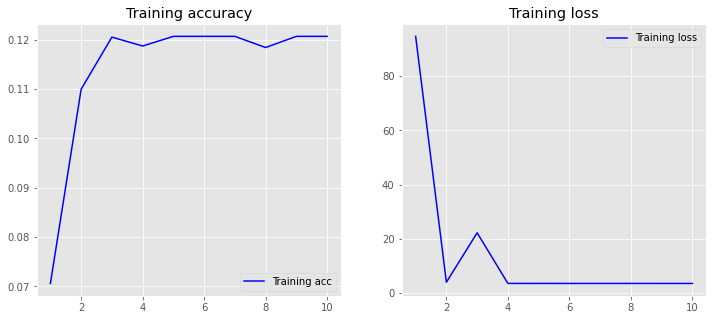

In [433]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    # Source: https://realpython.com/python-keras-text-classification/
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    #plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    #plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training loss')
    plt.legend()

plot_history(hist)

In [316]:
def nlp_model(num_classes, 
              vocab_size, 
             output_dim):
    inputs_body = [layers.Input(shape=(60,), name="body_"+str(i)) for i in range(3)]
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=300) # input_length is the length of the sequence of words in a sentence. is typically used when having a sequence of symbols as input (think sequence of words).
    bodies = [embedding(bod) for bod in inputs_body]
    bodies = layers.Concatenate()(bodies)
    conv = layers.Conv1D(128, 5, activation="relu")(bodies)
    pool = layers.GlobalMaxPooling1D()(conv) # puts it into a lower dimension
    
    # flatten volume, then FC -> RELU etc
    x = layers.Flatten()(pool)
    x = layers.Dense(num_classes*10, activation="relu")(x) # new
    x = layers.Dense(num_classes*5, activation="relu")(x) # new
    
    #apply FC to match the number of nodes
    x = layers.Dense(num_classes)(x)
    #output = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs_body, x)
    #model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.03),metrics=["accuracy"])

    return model
"""
num_of_articles = num_articles 
output_dim = num_of_articles

mlp = nlp_model(num_of_articles, vocab_size_body, output_dim)
mlp.summary()
"""

'\nnum_of_articles = num_articles \noutput_dim = num_of_articles\n\nmlp = nlp_model(num_of_articles, vocab_size_body, output_dim)\nmlp.summary()\n'

In [317]:
def mlp_model(num_of_articles, 
                  article_emb_dim, 
                  vocab_size,
                  vocab_size_body,
                  hidden_size1, 
                  hidden_size2, 
                  hidden_size3,
                 output_size):
    
    # bodies.shape = (6630, 3, 60)
    # arr_news.shape = (6630,8)
    # arr_author.shape = (6630, 8)
    
    input_article = layers.Input(shape=(8,), name="articles")
    article_emb = layers.Embedding(input_dim=num_of_articles, output_dim=article_emb_dim, input_length=8)(input_article)
    article = layers.GlobalAveragePooling1D()(article_emb)
    
    input_author = layers.Input(shape=(8,), name="authors")
    author_emb = layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=8)(input_author)
    author = layers.GlobalAveragePooling1D()(author_emb)
    
    x = layers.Concatenate()([author, article]) # Note, embeddings are concatinated
    
    #video_watches, search_tokens,context, hist_count
    x = layers.Dense(num_of_articles*2, activation="relu")(x)
    #x = layers.Dense(hidden_size2, activation="relu")(x)
    #x = layers.Dense(hidden_size3, activation="relu")(x)
    
    # FC layer to match size
    x = layers.Dense(num_of_articles, activation="relu")(x)

    model = keras.Model([input_article, input_author], x)
    #model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.03),metrics=["accuracy"])
    
    return model
"""
num_of_articles = num_articles    
vocab_size = len(author_to_id) +1
article_emb_dim = 16   
hidden_size1 = 512 # TODO: experiment with hidden sizes: num_of_articles * constant
hidden_size2 = 64
hidden_size3 = 32
output_size = 300
mlp = mlp_model(num_of_articles, 
                      article_emb_dim, 
                      vocab_size,
                      vocab_size_body,
                      hidden_size1,
                      hidden_size2,
                      hidden_size3,
                       output_size)
mlp.summary()
"""

'\nnum_of_articles = num_articles    \nvocab_size = len(author_to_id) +1\narticle_emb_dim = 16   \nhidden_size1 = 512 # TODO: experiment with hidden sizes: num_of_articles * constant\nhidden_size2 = 64\nhidden_size3 = 32\noutput_size = 300\nmlp = mlp_model(num_of_articles, \n                      article_emb_dim, \n                      vocab_size,\n                      vocab_size_body,\n                      hidden_size1,\n                      hidden_size2,\n                      hidden_size3,\n                       output_size)\nmlp.summary()\n'

In [318]:
#hist_mlp = mlp.fit([np.array(arr_news), np.array(arr_author)], np.array(y), epochs=10, batch_size=64)

In [330]:
def main_model(num_of_articles, article_emb_dim, vocab_size,
               hidden_size1,
               hidden_size2,
               hidden_size3,
               output_size,
               vocab_size_body,
               output_dim):
    mlp = mlp_model(num_of_articles, 
                          article_emb_dim, 
                          vocab_size,
                          vocab_size_body,
                          hidden_size1,
                          hidden_size2,
                          hidden_size3,
                          output_size)
    nlp = nlp_model(num_of_articles, vocab_size_body, output_dim)
    
    combined = layers.Concatenate()([mlp.output, nlp.output])
    
    x = layers.Dense(num_of_articles, activation="relu")(combined)
    x = layers.Dense(num_of_articles, activation="softmax")(x)
    model = keras.Model([mlp.input, nlp.input], x)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(0.03),
                  metrics=["accuracy"]
                 )
    return model

    
    
num_of_articles = num_articles    # 1 is for padding
vocab_size = len(author_to_id) +1

#author_to_id, id_to_author
# tuneable hyper-parameters
article_emb_dim = 16   
hidden_size1 = 256 # TODO: experiment with hidden sizes: num_of_articles * constant
hidden_size2 = 64
hidden_size3 = 32

test_model = main_model(num_of_articles,
                        article_emb_dim,
                        vocab_size,
                        vocab_size_body,
                          hidden_size1,
                          hidden_size2,
                          hidden_size3,
                          output_size, output_dim)
test_model.summary()

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body_0 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
body_1 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
body_2 (InputLayer)             [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_151 (Embedding)       (None, 60, 300)      90000       body_0[0][0]                     
                                                                 body_1[0][0]              

In [331]:
hist = test_model.fit([np.array(arr_news), np.array(arr_author), bodies], 
                 np.array(y), 
                 epochs=10, 
                 batch_size=64,
                )

Epoch 1/10


AssertionError: in user code:

    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /Users/eivindfalun/opt/anaconda3/envs/dnnrs/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:569 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 490), dtype=tf.float32, name=None), name='dense_168/Softmax:0', description="created by layer 'dense_168'")
